## CIFAR-10 Data Preprocessing for Hopfield Networks and Phase Space Learning

### Step 1: Install and Import Required Libraries

In [151]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import importlib

# import models
import hopfield_baseline
import storkey
import spiking

### Step 2: Load the CIFAR-10 Dataset

In [3]:
# defining a transform for converting images to grayscale and tensors
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

# Load training and test datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
color_trainset = datasets.CIFAR10(root='./data', train=True, download=True)

print(f'Training set size: {len(train_dataset)}')

Training set size: 50000


### Step 3: Binarize the Images to -1/+1

In [4]:
# convert images to numpy arrays
train_images = torch.stack([img for img,_ in train_dataset]).numpy()

# binarize the images
train_images = np.where(train_images > 0.5, 1, -1)

# verify the range of values
print(f'Unique pixel values after binarization: {np.unique(train_images)}')

Unique pixel values after binarization: [-1  1]


### Step 4: Reshape Images into 1024-bit Vectors

In [5]:
train_images = train_images.reshape(len(train_images), -1)

### Step 6: Visualize Some Binarized Images

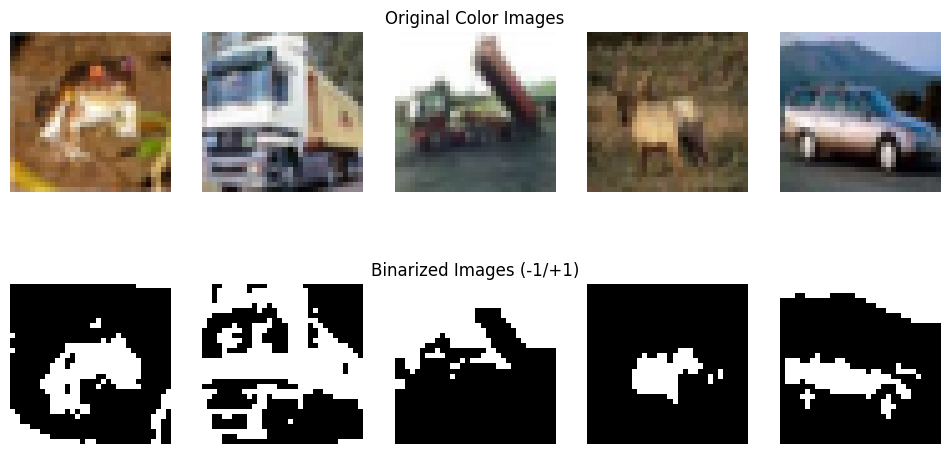

In [6]:
num_images = 5
fig, axes = plt.subplots(2,num_images,figsize=(12,6))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')

plt.show()

### Step 7: Generate a Corrupted Subset of Training Images

In [7]:
def corrupt_images(images, corruption_type="mask ", corruption_fraction=0.25):
    """
    Corrupt images by either masking pixels or flipping them

    Args:
        images (numpy array): binarized images to corrupt
        corruption_type (str): "mask" to set pixels to 0, "flip" to invert pixels
        corruption_fraction (float): Fraction of pixels to corrupt

    Returns:
        numpy array: Corrupted images
    """
    corrupted_images = images.copy()
    num_pixels = images.shape[1]
    num_corrupt = int(corruption_fraction * num_pixels)

    for img in corrupted_images:
        corrupt_indices = np.random.choice(num_pixels, num_corrupt, replace=False)

        if corruption_type == 'mask':
            img[corrupt_indices] = 0
        elif corruption_type == 'flip':
            img[corrupt_indices] *= -1
    return corrupted_images

In [8]:
# create corrupted images to use as test set
masked_images = corrupt_images(train_images, corruption_type='mask', corruption_fraction=0.25)
flipped_images = corrupt_images(train_images, corruption_type='flip', corruption_fraction=0.25)

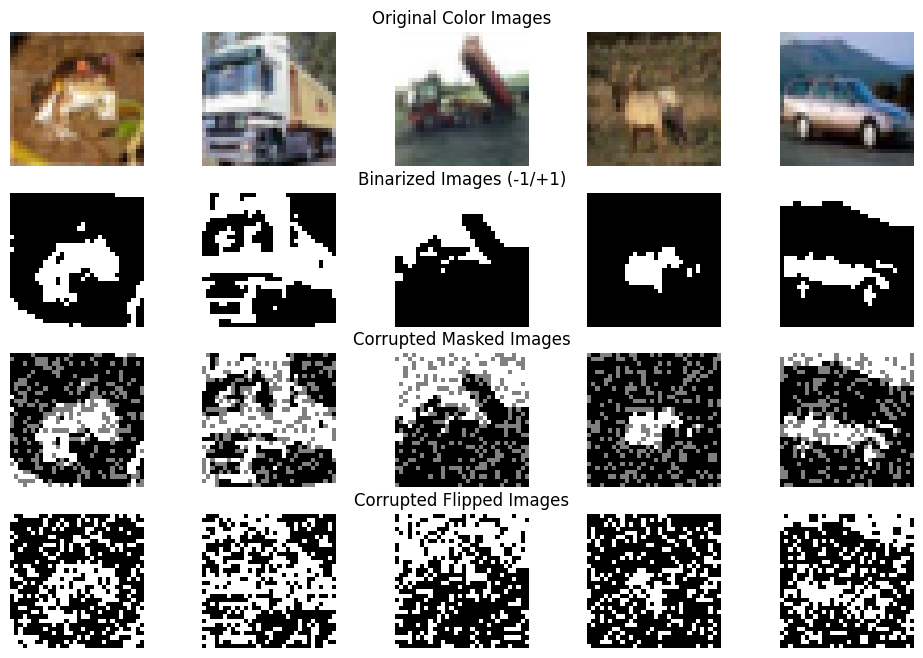

In [9]:
# Visualize some corrupted images

num_images = 5
fig, axes = plt.subplots(4,num_images,figsize=(12,8))
for i in range(num_images):
    # Plot the original color images
    axes[0,i].imshow(color_trainset.data[i])
    axes[0,i].axis('off')

    # Plot binarized grayscale images
    axes[1,i].imshow(train_images[i].reshape(32,32), cmap='gray')
    axes[1,i].axis('off')

    # Plot corrupted masked images
    axes[2,i].imshow(masked_images[i].reshape(32,32), cmap='gray')
    axes[2,i].axis('off')

    # Plot corrupted flipped images
    axes[3,i].imshow(flipped_images[i].reshape(32,32), cmap='gray')
    axes[3,i].axis('off')

axes[0,num_images//2].set_title('Original Color Images', fontsize=12, loc='center')
axes[1,num_images//2].set_title('Binarized Images (-1/+1)', fontsize=12, loc='center')
axes[2,num_images//2].set_title('Corrupted Masked Images', fontsize=12, loc='center')
axes[3,num_images//2].set_title('Corrupted Flipped Images', fontsize=12, loc='center')


plt.show()

### Step 8: Save the Preprocessed Datasets

In [10]:
# Create 'data/binarized' directory if it doesn't exist
if not os.path.isdir('data/binarized'):
    os.mkdir('data/binarized')

np.save("data/binarized/train_images.npy", train_images)
np.save("data/binarized/masked_images.npy", masked_images)
np.save("data/binarized/flipped_images.npy", flipped_images)


## Training Baseline

In [149]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

# convert to PyTorch tensors
stored_images = torch.tensor(stored_images, dtype=torch.float32)
masked_images = torch.tensor(masked_images, dtype=torch.float32)
flipped_images = torch.tensor(flipped_images, dtype=torch.float32)

In [152]:
importlib.reload(hopfield_baseline)
num_neurons = 1024
num_patterns = 5
hopfield_rnn = hopfield_baseline.HopfieldRNN(num_units=num_neurons)

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)

baseline_original = stored_images[idxs]
baseline_masked = masked_images[idxs]
baseline_flipped = flipped_images[idxs]

# store patterns using Hebbian learning
hopfield_rnn.store_patterns(baseline_original)

In [153]:
# Retrieve images from corrupted inputs
retrieved_masked = hopfield_rnn(baseline_masked)
retrieved_flipped = hopfield_rnn(baseline_flipped)

In [154]:
criterion = nn.MSELoss()

loss_masked = criterion(baseline_original, retrieved_masked)
loss_flipped = criterion(baseline_original, retrieved_flipped)

print(f"Reconstruction MSE Loss (Masked Images): {loss_masked.item():.4f}")
print(f"Reconstruction MSE Loss (Flipped Images): {loss_flipped.item():.4f}\n")

# Compute SSE using PyTorch's MSE function with reduction='sum'
loss_masked = hopfield_rnn.recall_loss(baseline_masked, baseline_original)
loss_flipped = hopfield_rnn.recall_loss(baseline_flipped, baseline_original)

print(f"Reconstruction Loss (Masked Images - SSE): {loss_masked.item():.4f}")
print(f"Reconstruction Loss (Flipped Images - SSE): {loss_flipped.item():.4f}\n")

masked_acc = hopfield_rnn.recall_accuracy(baseline_masked, baseline_original)
flipped_acc = hopfield_rnn.recall_accuracy(baseline_flipped, baseline_original)

print(f"Reconstruction Accuracy (Masked Images): {masked_acc:.4f}")
print(f"Reconstruction Accuracy (Flipped Images): {flipped_acc:.4f}")

Reconstruction MSE Loss (Masked Images): 0.1398
Reconstruction MSE Loss (Flipped Images): 0.1398

Reconstruction Loss (Masked Images - SSE): 716.0000
Reconstruction Loss (Flipped Images - SSE): 716.0000

Reconstruction Accuracy (Masked Images): 0.2000
Reconstruction Accuracy (Flipped Images): 0.2000


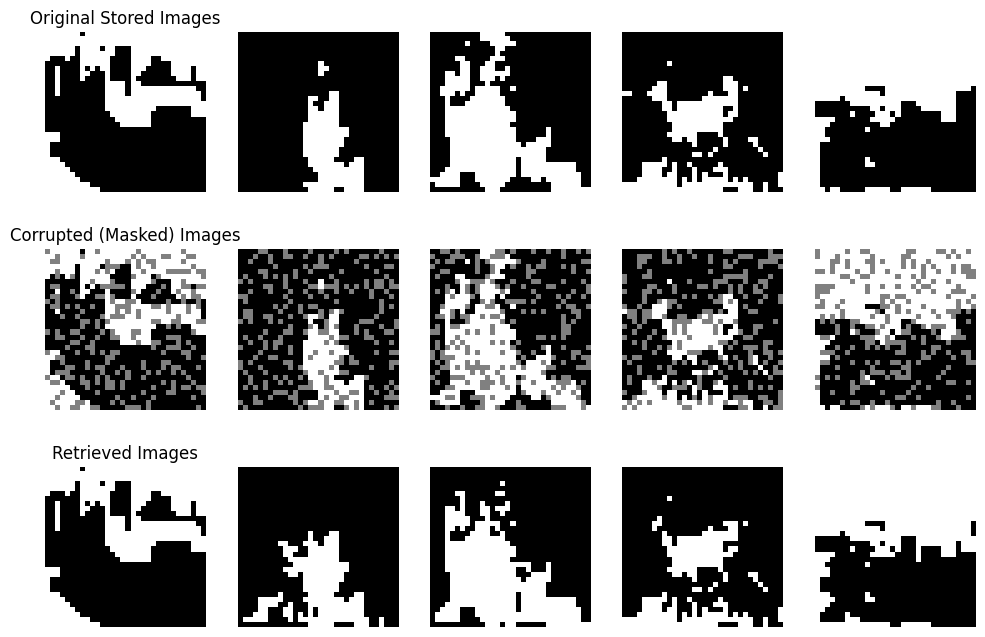

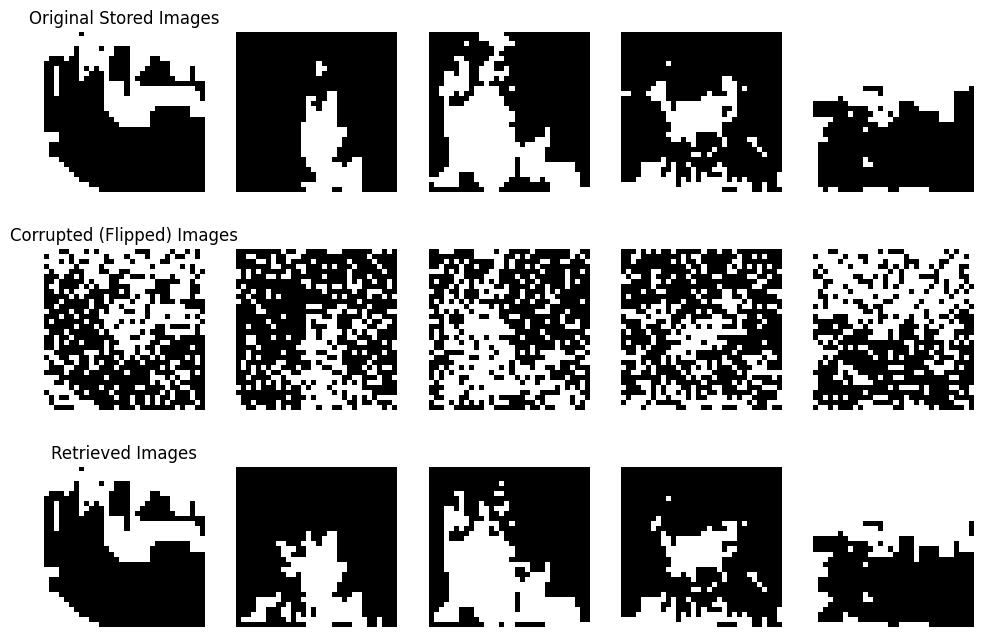

In [155]:
import matplotlib.pyplot as plt

def plot_comparisons(original, corrupted, retrieved, title_corrupted, title_retrieved, num_samples=5):

    fig, axes = plt.subplots(3, num_samples, figsize=(12, 8))

    for i in range(num_samples):
        # Original stored image
        axes[0, i].imshow(original[i].reshape(32, 32), cmap='gray')
        axes[0, i].axis('off')

        # Corrupted image
        axes[1, i].imshow(corrupted[i].reshape(32, 32), cmap='gray')
        axes[1, i].axis('off')

        # Retrieved image
        axes[2, i].imshow(retrieved[i].reshape(32, 32), cmap='gray')
        axes[2, i].axis('off')

    # Add row titles
    axes[0, 0].set_title("Original Stored Images", fontsize=12, loc='center')
    axes[1, 0].set_title(title_corrupted, fontsize=12, loc='center')
    axes[2, 0].set_title(title_retrieved, fontsize=12, loc='center')

    plt.show()

# Plot results for masked images
plot_comparisons(baseline_original.numpy(), baseline_masked.numpy(), retrieved_masked.detach().numpy(),
                 "Corrupted (Masked) Images", "Retrieved Images")

# Plot results for flipped images
plot_comparisons(baseline_original.numpy(), baseline_flipped.numpy(), retrieved_flipped.detach().numpy(),
                 "Corrupted (Flipped) Images", "Retrieved Images")


## Training Spiking

In [ ]:
# load training data
stored_images = np.load("data/binarized/train_images.npy")
masked_images = np.load("data/binarized/masked_images.npy")
flipped_images = np.load("data/binarized/flipped_images.npy")

In [ ]:
importlib.reload(spiking)

spyking_model = spiking.SpikingHN(N=1024)

num_patterns = 15

# randomly select from training set
idxs = np.random.choice(range(len(stored_images)), size=num_patterns, replace=False)
spyking_patterns = stored_images[idxs]
spyking_masked = masked_images[idxs]
spyking_flipped = flipped_images[idxs]

spyking_model.train(spyking_patterns)


In [146]:
firings, voltages = spyking_model.forward(spyking_masked[0])

### Recalling Increasing Number of Patterns